In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import multiprocessing
import torchvision
import timm
import os
from transformers import *
from datasets import load_dataset
from PIL import Image
from torchinfo import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
import time

torch.cuda.empty_cache()
device="cuda" if torch.cuda.is_available() else "cpu"

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.0.1+cu117)
    Python  3.9.18 (you have 3.9.17)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


### Loading in data and pretrained model

In [2]:
timm.list_models("vit*",pretrained=True)

['vit_base_patch8_224.augreg2_in21k_ft_in1k',
 'vit_base_patch8_224.augreg_in21k',
 'vit_base_patch8_224.augreg_in21k_ft_in1k',
 'vit_base_patch8_224.dino',
 'vit_base_patch14_dinov2.lvd142m',
 'vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'vit_base_patch16_224.augreg_in1k',
 'vit_base_patch16_224.augreg_in21k',
 'vit_base_patch16_224.augreg_in21k_ft_in1k',
 'vit_base_patch16_224.dino',
 'vit_base_patch16_224.mae',
 'vit_base_patch16_224.orig_in21k_ft_in1k',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch16_224_miil.in21k',
 'vit_base_patch16_224_miil.in21k_ft_in1k',
 'vit_base_patch16_384.augreg_in1k',
 'vit_base_patch16_384.augreg_in21k_ft_in1k',
 'vit_base_patch16_384.orig_in21k_ft_in1k',
 'vit_base_patch16_clip_224.datacompxl',
 'vit_base_patch16_clip_224.laion2b',
 'vit_base_patch16_clip_224.laion2b_ft_in1k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k',
 'vit_base_patch16_clip_224.openai',
 'vit_base_patch16_clip_224.openai

In [3]:
batch_size=8
cpu_count=multiprocessing.cpu_count()
model_name="eva02_base_patch14_448.mim_in22k_ft_in22k_in1k"

model = timm.create_model(model_name, pretrained=True)

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

transform_data=torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224,224)),
                                                torchvision.transforms.ToTensor()])

train_data=torchvision.datasets.ImageFolder("./data/train",transform=transforms)
test_data=torchvision.datasets.ImageFolder("./data/test",transform=transforms)

train_loader=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
test_loader=torch.utils.data.DataLoader(test_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)

##### Freezing layers

In [4]:
count=0
for param in model.parameters(): #236 params
    if(count>=120):
        break
    param.requires_grad=False
    count+=1

##### Model Modification

In [5]:
#Changing the classification part
model.head=nn.Linear(in_features=model.head.in_features,out_features=1024)

class modified_vit(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model=model
        self.sequential=nn.Sequential(nn.Linear(in_features=1024,out_features=2048),
                                      nn.ReLU(),
                                      nn.Linear(in_features=2048,out_features=512),
                                      nn.ReLU(),
                                      nn.Linear(in_features=512,out_features=256),
                                      nn.ReLU(),
                                      nn.Linear(in_features=256,out_features=128),
                                      nn.ReLU(),
                                      nn.Linear(in_features=128,out_features=2))
    def forward(self,x):
        return self.sequential(self.model(x))

In [6]:
#model=modified_vit(model)
model=model.to(device)

In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
Eva                                      787,968
├─PatchEmbed: 1-1                        --
│    └─Conv2d: 2-1                       (452,352)
│    └─Identity: 2-2                     --
├─Dropout: 1-2                           --
├─RotaryEmbeddingCat: 1-3                --
├─ModuleList: 1-4                        --
│    └─EvaBlock: 2-3                     --
│    │    └─LayerNorm: 3-1               (1,536)
│    │    └─EvaAttention: 3-2            (2,361,600)
│    │    └─Identity: 3-3                --
│    │    └─LayerNorm: 3-4               (1,536)
│    │    └─SwiGLU: 3-5                  (4,727,552)
│    │    └─Identity: 3-6                --
│    └─EvaBlock: 2-4                     --
│    │    └─LayerNorm: 3-7               (1,536)
│    │    └─EvaAttention: 3-8            (2,361,600)
│    │    └─Identity: 3-9                --
│    │    └─LayerNorm: 3-10              (1,536)
│    │    └─SwiGLU: 3-11                 (4,727,552)
│  

In [8]:
model

Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (rope): RotaryEmbeddingCat()
  (blocks): ModuleList(
    (0-11): 12 x EvaBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (k_proj): Linear(in_features=768, out_features=768, bias=False)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (fc1_g): Linear(in_features=768, out_features=2048, bias=True)
        (fc1_x): Linear(in_features=76

### Visualizing Transformed Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


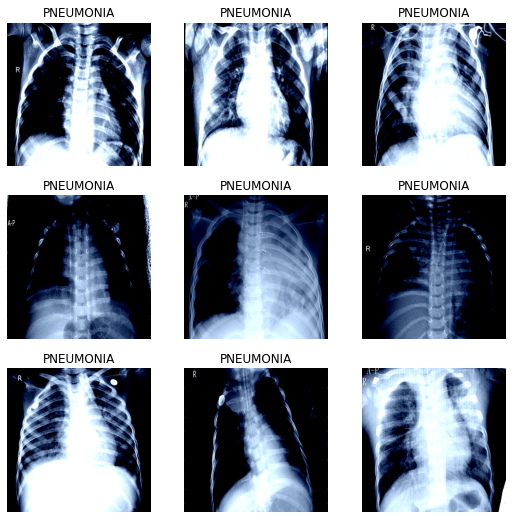

In [9]:
plt.figure(figsize=(9,9))
for i in range(1,10):
    data=next(iter(train_loader))
    rand_ind=torch.randint(0,batch_size-1,size=(1,)).item()
    label=data[1][rand_ind]
    image=data[0][rand_ind].permute(1,2,0)
    plt.title(train_data.classes[label.item()])
    plt.subplot(3,3,i)
    plt.axis(False)
    plt.imshow(image)
    

### Optimizer and Loss and Logdir

In [10]:
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

In [11]:
log_dir = "./"+model_name+"feature_extractor_tensorboard"
writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)
    

### Testing model

In [12]:
model.eval()
with torch.inference_mode():
    x,y=next(iter(train_loader))
    x=x.to(device)
    y=y.to(device)
    logits=model(x)
    print(logits)
    print(loss_fn(logits.squeeze(),y))
    print(accuracy_fn(logits,y))

tensor([[ 0.0307,  0.0484, -1.9510,  ..., -0.8695, -1.0215,  1.8524],
        [-0.8545, -0.0637, -1.9237,  ..., -0.7943, -0.4108,  1.4291],
        [-0.3282,  0.2148, -2.3317,  ..., -0.5611, -1.2854,  1.5165],
        ...,
        [-0.3733, -0.0690, -1.9734,  ..., -0.6783, -1.5051,  1.5299],
        [-0.6039,  0.2824, -1.8604,  ..., -0.4257, -1.0232,  1.6568],
        [-1.1348,  0.0717, -2.4400,  ..., -0.5403, -0.6560,  1.5136]],
       device='cuda:0')
tensor(7.3682, device='cuda:0')
0.0


### Training Loop

In [13]:
epochs=10

train_accuracy=[]
test_accuracy=[]
train_loss=[]
test_loss=[]

for i in tqdm(range(epochs)):
    print("Training:")
    model.train()
    
    #Defining accuracy and loss for train and test data
    temp_train_accuracy=[]
    temp_test_accuracy=[]
    temp_train_loss=[]
    temp_test_loss=[]

    net_train_accuracy=0
    net_test_accuracy=0
    net_train_loss=0
    net_test_loss=0
    
    with tqdm(total=len(train_loader)) as pbar:
        for x,y in train_loader:
                x=x.to(device)
                y=y.to(device)
    
                #Calculating model output
                logits=model(x)
    
                #Reseting any old gradient values
                optimizer.zero_grad()
                loss=loss_fn(logits.squeeze(),y)

            
                #Track of metrics        
                accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                temp_train_accuracy.append(accuracy_train)
                temp_train_loss.append(loss.item())
    
                #Back Propogation
                loss.backward()
            
                #Update Parameters
                optimizer.step()
            
                #Progress Bar Update
                pbar.update(1)
        pbar.close()
    #Tensorboard & Metrics for the dataset
    net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
    net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    train_accuracy.append(net_train_accuracy)
    train_loss.append(net_train_loss)
    writer.add_scalar("Train Accuracy",net_train_accuracy,i)
    writer.add_scalar("Train Loss",net_train_loss,i)

    #Evaluation
    print("Testing:")
    model.eval()

    with tqdm(total=len(test_loader)) as pbar2:
        for x,y in test_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(logits.squeeze().type(torch.float32),y)

                #Track of metrics
                accuracy_test=accuracy_fn(logits,y)
                temp_test_accuracy.append(accuracy_test)
                temp_test_loss.append(loss.item())

                #Progress Bar Update
                pbar2.update(1)
        pbar2.close()

    #Tensorboard & Metrics for the dataset
    net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
    net_test_loss=sum(temp_test_loss)/len(temp_test_loss)
    test_accuracy.append(net_test_accuracy)
    test_loss.append(net_test_loss)
    writer.add_scalar("Test Accuracy",net_test_accuracy,i)
    writer.add_scalar("Test Loss",net_test_loss,i)

    '''
    #Saving the model
    try:
        os.makedirs(f"./{model_name}_feature_extractor/")
    except Exception as e:
        pass
    torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
    '''
    
    print(f"Epoch {i+1}:\nTrain Accuracy: {net_train_accuracy}  Train Loss: {net_train_loss}  Test Accuracy: {net_test_accuracy}  Test Loss: {net_test_loss}")
    print("\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:


  0%|          | 0/548 [00:00<?, ?it/s]

Testing:


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1:
Train Accuracy: 0.8706660583941606  Train Loss: 0.36545861579892464  Test Accuracy: 0.9269125683060109  Test Loss: 0.18100019797550443


Training:


  0%|          | 0/548 [00:00<?, ?it/s]

Testing:


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2:
Train Accuracy: 0.9363594890510949  Train Loss: 0.16932587328754206  Test Accuracy: 0.9480874316939891  Test Loss: 0.17943252995355777


Training:


  0%|          | 0/548 [00:00<?, ?it/s]

Testing:


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3:
Train Accuracy: 0.9632755474452555  Train Loss: 0.11013897793146252  Test Accuracy: 0.9556010928961749  Test Loss: 0.11925487374744373


Training:


  0%|          | 0/548 [00:00<?, ?it/s]

Testing:


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4:
Train Accuracy: 0.9669251824817519  Train Loss: 0.09520352188920583  Test Accuracy: 0.9569672131147541  Test Loss: 0.1091293922531332


Training:


  0%|          | 0/548 [00:00<?, ?it/s]

Testing:


  0%|          | 0/183 [00:00<?, ?it/s]

Epoch 5:
Train Accuracy: 0.9728558394160584  Train Loss: 0.08072903001942056  Test Accuracy: 0.950136612021858  Test Loss: 0.14413312467847583


Training:


  0%|          | 0/548 [00:00<?, ?it/s]

KeyboardInterrupt: 